In [5]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from sidequests.scratch import ( # !
    ReLU,
    Adam as optAdam,
    CrossEntropy as critCrossEntropy,
    LinearLayer,
    Conv2D,
    MaxPool2D,
    DifferentiableModule
)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
# Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.set_default_device(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.to(device)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

N = 5
generator = torch.Generator(device=device) # For shuffling
torch.manual_seed(1234)

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=N, shuffle=True, num_workers=2, generator=generator)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=N, shuffle=False, num_workers=2, generator=generator)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

print("Train set", len(trainset))
print("Test set", len(testset))

Device: cuda
Train set 50000
Test set 10000


1. 220.39810466766343
2. 186.44573888778694
3. 174.7393159627913
4. 167.71211913824087
5. 164.63789787292464
6. 160.69521409273145
7. 158.440863507986
8. 155.90254645347588
9. 153.928430068493
10. 151.846157002449
11. 147.1080193400382
12. 149.7808437824248
13. 144.2232752978802
14. 145.41933972239502
15. 146.10040591359132
16. 140.73630093336104
17. 142.92815054059045
18. 140.45905210971827
19. 135.7459030866623
20. 136.9676633894443


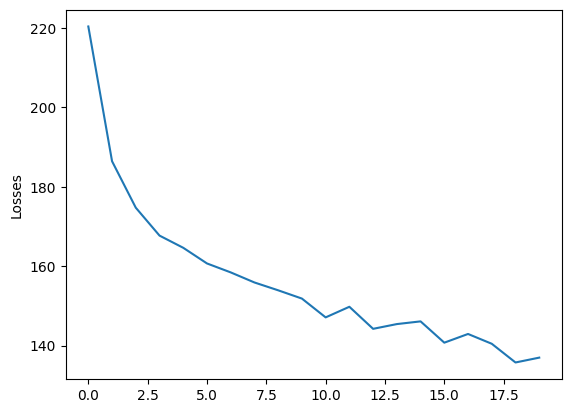

In [7]:
# Train
class NetVanilla(DifferentiableModule):
    def __init__(self):
        self.conv1 = Conv2D(3, 6, 5) # stride=1, padding=0
        self.pool = MaxPool2D(2, 2)
        self.conv2 = Conv2D(6, 10, 3)
        self.fc1 = LinearLayer(10 * 6 * 6, 69)
        self.fc2 = LinearLayer(69, 142)
        self.fc3 = LinearLayer(142, 10)

    def forward(self, x):
        # x is (N, 3, 32, 32)
        relu = ReLU()
        x = relu(self.conv1.forward(x))       # (N, 6, 28, 28)
        x = self.pool.forward(x)              # (N, 10, 14, 14)
        x = relu(self.conv2.forward(x))       # (N, 10, 12, 12)
        x = self.pool.forward(x)              # (N, 10, 6, 6)
        x = x.view(-1, 10 * 6 * 6)            # (N, 10, 6, 6) -> (N, 10 * 6 * 6)
        x = relu(self.fc1.forward(x))         # (N, 69)
        x = relu(self.fc2.forward(x))         # (N, 142)
        x = self.fc3.forward(x)               # (N, 10)
        return x

    def params(self):
        return (
            self.conv1.params()
            + self.conv2.params()
            + self.fc1.params()
            + self.fc2.params()
            + self.fc3.params()
        )

net = NetVanilla()
custom_optimizer = optAdam(lr=0.001)
criterion = critCrossEntropy()
losses = []
take_train_max = 500

epochs = 20
for epoch in range(epochs):  
    total_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i >= take_train_max:
            break
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        net.reset()
        logits = net.forward(inputs)
        loss = criterion(logits, labels) # 10 classes -> cross_entropy((N, 10), (N))
        loss.backward()

        custom_optimizer(net.params())

        total_loss += loss.item() / N

    losses.append(total_loss)
    print(f"{epoch + 1}. {total_loss}")

# We should reach around 30% just like the full Pytorch version
plt.plot(losses)
plt.ylabel("Losses")
plt.show()

In [8]:
correct = 0
total = 0
take_test_max = 500
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        if i >= take_test_max:
            break
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        logits = net.forward(images)
        _, best_index_per_sample = torch.max(logits.data, 1)
        assert len(best_index_per_sample) == N

        for pre_idx, true_idx in zip(best_index_per_sample, labels):
            pred, true = classes[pre_idx], classes[true_idx]
            verdict = pred == true
            if total % 100 == 0 or (verdict and torch.rand(1) < 0.5):
                print(f"A {true} is a {pred}? {verdict}")

        correct += (best_index_per_sample == labels).sum().item()
        total += len(labels)

print(f"Accuracy over {epochs} epochs on the {take_test_max} first test images: {100 * correct /  total}%")

A cat is a car? False
A ship is a car? False
A ship is a car? False
A plane is a car? False
A frog is a car? False
A car is a car? True
A truck is a truck? True
A truck is a truck? True
A truck is a truck? True
A ship is a ship? True
A horse is a horse? True
A horse is a horse? True
A bird is a bird? True
A plane is a plane? True
A bird is a bird? True
A truck is a truck? True
A ship is a ship? True
A car is a car? True
A car is a car? True
A truck is a truck? True
A frog is a frog? True
A deer is a horse? False
A dog is a horse? False
A frog is a frog? True
A cat is a frog? False
A car is a car? True
A bird is a bird? True
A plane is a plane? True
A ship is a ship? True
A dog is a car? False
A car is a truck? False
A ship is a ship? True
A horse is a car? False
A car is a frog? False
A cat is a cat? True
A truck is a truck? True
A dog is a dog? True
A frog is a frog? True
A ship is a ship? True
A car is a car? True
A truck is a truck? True
A truck is a truck? True
A plane is a plane? 